- Add extra features
- Perform PCA GridSearch with RandomForest
- Check performance overall and then for targets 2 vs. 3

In [1]:
from kernel_submission_2 import *

/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/minnie/

ValueError: could not convert string to float: 'd237404b6'

In [2]:
train_df = load_train_data()
hh_level = compress_to_household_level(train_df)

/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [84]:
len(train_df)

9557

In [81]:
hh_level.reset_index()[household_id].nunique()

2988

In [66]:
# hh_level = hh_level.loc[hh_level[target_column].isin([2,3])]
data = get_balanced_data(convert_to_binary_targets(hh_level,4))

In [67]:
X = data.drop(target_column, axis=1)
y = data[target_column]

Get best parameters except for the number of estimators, which poses a time / quality tradeoff

In [ ]:
import numpy as np

from time import time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# use a full grid over all parameters
param_grid = {"max_depth": [4, 3, 2, None],
              "max_features": [None],
              "min_samples_split": [2, 3, 8, 10],
              "min_samples_leaf": [1, 3, 10, 15],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring=scorer)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer


clf = RandomForestClassifier(random_state=10, n_jobs = -1,
                            bootstrap=True, criterion='gini', 
                             max_depth=4, max_features=None)

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', clf)
])

N_FEATURES_OPTIONS = [12]
N_ESTIMATORS_OPTIONS = [25, 50, 75, 100]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__n_estimators': N_ESTIMATORS_OPTIONS
    }
]
reducer_labels = ['PCA']

scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid, scoring=scorer)
grid = grid.fit(X, y)

In [75]:
np.array(grid.cv_results_['mean_test_score']).reshape(len(N_ESTIMATORS_OPTIONS), -1, len(N_FEATURES_OPTIONS))

array([[[0.73009269]],

       [[0.72805041]],

       [[0.73193909]],

       [[0.73038629]]])

In [8]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(N_ESTIMATORS_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best n_estimators
mean_scores = mean_scores.max(axis=0)

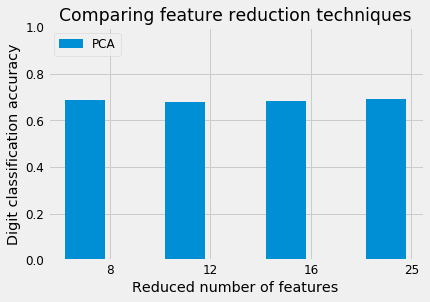

In [9]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 12
plt.rcParams['patch.edgecolor'] = 'k'

bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)
plt.figure()
# COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label)#, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

In [77]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

v = get_balanced_data(data, 50, 12)
t = pd.concat([data.reset_index(), v.reset_index()]).drop_duplicates(keep=False).set_index(household_id)

train_labels = np.array(list(t[target_column].astype(np.uint8)))
train_set = t.drop(columns = [target_column])
test_set = v.drop(columns = [target_column])


pipe = Pipeline([
    ('reduce_dim', PCA(n_components=12)),
])

train_set = pipe.fit_transform(train_set)
test_set = pipe.transform(test_set)

clf = RandomForestClassifier(random_state=10, n_jobs = -1,
                            bootstrap=True, criterion='gini', 
                             max_depth=4, max_features=None,
                            n_estimators=25)

# clf = RandomForestClassifier(n_estimators=8, random_state=12, n_jobs = -1)
clf.fit(train_set, train_labels)
preds = clf.predict(test_set)
print(classification_report(v[target_column], preds))

             precision    recall  f1-score   support

          0       0.69      0.70      0.69        50
          1       0.69      0.68      0.69        50

avg / total       0.69      0.69      0.69       100



### Classifier Target 1

In [ ]:
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=25)),
])

train_set = pipe.fit_transform(train_set)
test_set = pipe.transform(test_set)

clf = RandomForestClassifier(random_state=10, n_jobs = -1,
                            bootstrap=True, criterion='gini', 
                             max_depth=4, max_features=None,
                            n_estimators=25)

### Classifier Target 2

In [ ]:
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=25)),
])

train_set = pipe.fit_transform(train_set)
test_set = pipe.transform(test_set)

clf = RandomForestClassifier(random_state=10, n_jobs = -1,
                            bootstrap=True, criterion='gini', 
                             max_depth=4, max_features=None,
                            n_estimators=50)

### Classifier Target 3

In [ ]:
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=19)),
])

train_set = pipe.fit_transform(train_set)
test_set = pipe.transform(test_set)

clf = RandomForestClassifier(random_state=10, n_jobs = -1,
                            bootstrap=True, criterion='gini', 
                             max_depth=4, max_features=None,
                            n_estimators=25)

### Classifier Target 4

In [ ]:
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=12)),
])

train_set = pipe.fit_transform(train_set)
test_set = pipe.transform(test_set)

clf = RandomForestClassifier(random_state=10, n_jobs = -1,
                            bootstrap=True, criterion='gini', 
                             max_depth=4, max_features=None,
                            n_estimators=25)

### Try loading test data

In [ ]:
test_df = pd.read_csv(filepath)
test_df = clean_data(test_df)
test_df = compress_columns(test_df, 'education-level', ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9'])
test_df = schooling_features(test_df)
ind_summed_info = get_individual_summed_info(test_df)
hh_mode_info = get_household_mode_info(test_df)
test_df = ind_summed_info.join(hh_mode_info)
# train_df = compress_column_data(train_df)
# train_df = add_custom_features(train_df)

In [2]:
test_df

NameError: name 'test_df' is not defined